<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/main/Classic_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install bm3d


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 20.3 MB/s eta 0:00:00


Denoised stamp saved to: /content/drive/MyDrive/sdss_image_dataset/new_augmented/train/denoised/frame-u-1045-4-110_nlmeans.npy


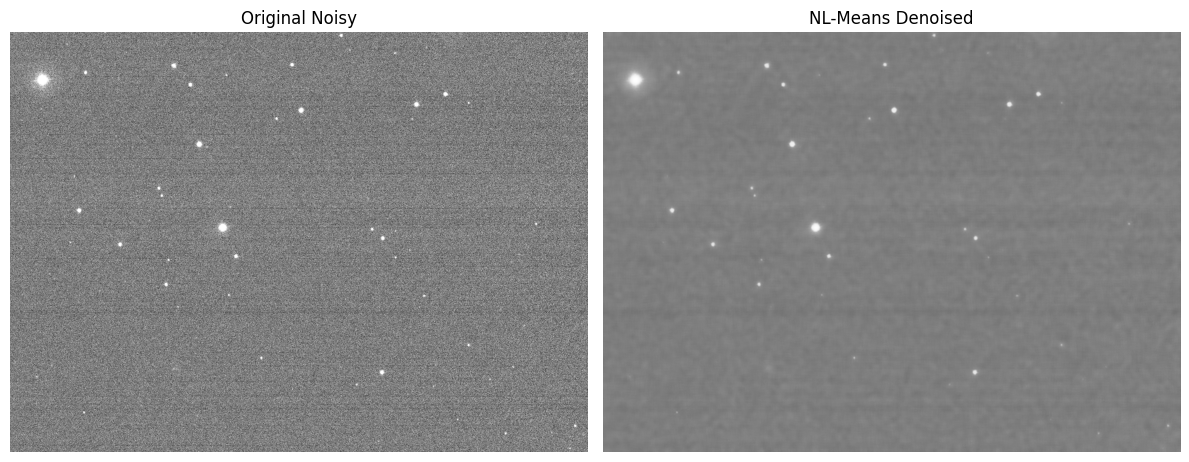

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma

# ─── CONFIG ─────────────────────────────────────────────────────────────
BASE_DIR    = "/content/drive/MyDrive/sdss_image_dataset/new_augmented/train"
NOISY_DIR   = os.path.join(BASE_DIR, "noisy")
STAMP_NAME  = "frame-u-1045-4-110.npy"  # the file you want to process
OUTPUT_DIR  = os.path.join(BASE_DIR, "denoised")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── PATHS ────────────────────────────────────────────────────────────────
noisy_path    = os.path.join(NOISY_DIR, STAMP_NAME)
denoised_name = STAMP_NAME.replace(".npy", "_nlmeans.npy")
denoised_path = os.path.join(OUTPUT_DIR, denoised_name)

# ─── LOAD NOISY STAMP ─────────────────────────────────────────────────────
noisy = np.load(noisy_path).astype(np.float32)
if noisy.ndim == 3 and noisy.shape[-1] == 1:
    noisy = noisy[..., 0]

# ─── NORMALIZE to [0,1] by 1–99 percentile ───────────────────────────────
p1, p99       = np.percentile(noisy, (1, 99))
noisy_clipped = np.clip(noisy, p1, p99)
noisy_norm    = (noisy_clipped - p1) / (p99 - p1 + 1e-8)

# ─── ESTIMATE NOISE σ AND DENOISE ─────────────────────────────────────────
# New API: no multichannel, use channel_axis=None
sigma_est = np.mean(estimate_sigma(noisy_norm, channel_axis=None))
denoised_norm = denoise_nl_means(
    noisy_norm,
    h=1.15 * sigma_est,
    patch_size=7,
    patch_distance=11,
    fast_mode=True,
    channel_axis=None
)

# ─── RESCALE back to original range ────────────────────────────────────────
denoised = denoised_norm * (p99 - p1) + p1

# ─── SAVE DENOISED STAMP ──────────────────────────────────────────────────
np.save(denoised_path, denoised)
print(f"Denoised stamp saved to: {denoised_path}")

# ─── DISPLAY BEFORE & AFTER ───────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
vmin, vmax = p1, p99

ax1.imshow(noisy, cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title("Original Noisy")
ax1.axis("off")

ax2.imshow(denoised, cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title("NL-Means Denoised")
ax2.axis("off")

plt.tight_layout()
plt.show()


PSNR: 4.71 dB
SSIM:  0.0211


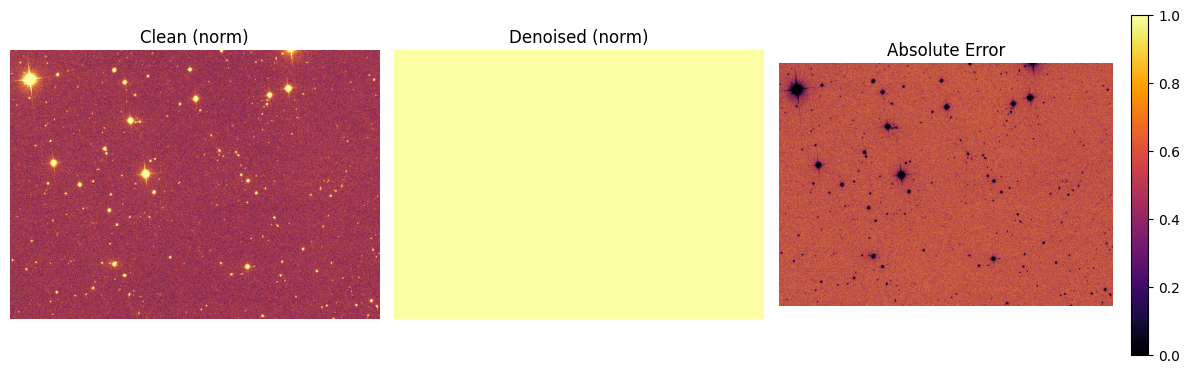

In [ ]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# ─── PATHS ─────────────────────────────────────────────────────────────────
NOISY_DENOISED = "/content/drive/MyDrive/sdss_image_dataset/new_augmented/train/denoised/frame-u-1045-4-110_nlmeans.npy"
CLEAN_STAMP    = "/content/drive/MyDrive/sdss_image_dataset/new_augmented/train/clean/frame-r-1045-4-110.npy"

# ─── LOAD ───────────────────────────────────────────────────────────────────
denoised = np.load(NOISY_DENOISED)
clean    = np.load(CLEAN_STAMP).astype(np.float32)
if clean.ndim==3 and clean.shape[-1]==1:
    clean = clean[...,0]

# ─── NORMALIZE CLEAN TO THE SAME RANGE ───────────────────────────────────────
p1, p99 = np.percentile(clean, (1,99))
clean_clipped = np.clip(clean, p1, p99)
clean_norm    = (clean_clipped - p1) / (p99 - p1 + 1e-8)

# Since we rescaled denoised back to the original data range (p1–p99),
# re-normalize it the same way:
denorm_clipped = np.clip(denoised, p1, p99)
denorm_norm    = (denorm_clipped - p1) / (p99 - p1 + 1e-8)

# ─── COMPUTE METRICS ────────────────────────────────────────────────────────
psnr_val = psnr(clean_norm, denorm_norm, data_range=1.0)
ssim_val = ssim(clean_norm, denorm_norm, data_range=1.0)

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM:  {ssim_val:.4f}")

# ─── VISUALIZE DIFFERENCE ────────────────────────────────────────────────────
fig, axs = plt.subplots(1,3,figsize=(12,4))
for ax, img, title in zip(
    axs,
    [clean_norm, denorm_norm, np.abs(clean_norm-denorm_norm)],
    ["Clean (norm)", "Denoised (norm)", "Absolute Error"]
):
    im = ax.imshow(img, cmap='inferno', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')
fig.colorbar(im, ax=axs[-1], fraction=0.046)
plt.tight_layout()
plt.show()


Saved denoised stamp to: /content/drive/MyDrive/sdss_image_dataset/new_augmented/train/denoised_tuned/frame-u-1045-4-110_nlmeans_tuned2.npy
PSNR: 4.56 dB   SSIM: 0.0085


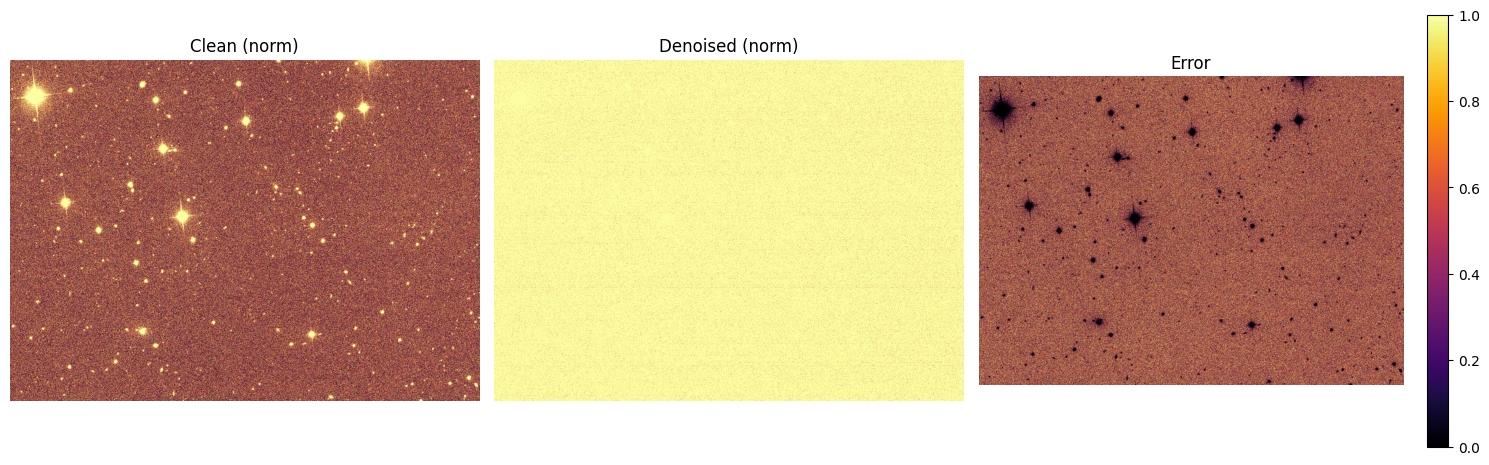

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# ─── CONFIG ───────────────────────────────────────────────────────────────
BASE      = "/content/drive/MyDrive/sdss_image_dataset/new_augmented/train"
NOISY_FN  = "frame-u-1045-4-110.npy"
NOISY_PATH = os.path.join(BASE, "noisy", NOISY_FN)

# Derive clean filename by replacing 'frame-u-' with 'frame-r-'
CLEAN_FN  = NOISY_FN.replace("frame-u-", "frame-r-")
CLEAN_PATH = os.path.join(BASE, "clean", CLEAN_FN)

DEN_DIR   = os.path.join(BASE, "denoised_tuned")
os.makedirs(DEN_DIR, exist_ok=True)
OUT_FN    = NOISY_FN.replace(".npy", "_nlmeans_tuned2.npy")
OUT_PATH  = os.path.join(DEN_DIR, OUT_FN)

# ─── LOAD & DROP CHANNEL ───────────────────────────────────────────────────
noisy = np.load(NOISY_PATH).astype(np.float32)
clean = np.load(CLEAN_PATH).astype(np.float32)

# If they have a singleton channel dimension, squeeze it
if noisy.ndim == 3 and noisy.shape[-1] == 1:
    noisy = noisy[..., 0]
if clean.ndim == 3 and clean.shape[-1] == 1:
    clean = clean[..., 0]

# ─── PERCENTILE NORMALIZATION (10–90%) ─────────────────────────────────────
p_lo, p_hi = np.percentile(clean, (10, 90))
clean_norm = np.clip((clean - p_lo) / (p_hi - p_lo + 1e-8), 0, 1)
noisy_norm = np.clip((noisy - p_lo) / (p_hi - p_lo + 1e-8), 0, 1)

# ─── NL-MEANS DENOISING (TUNED) ─────────────────────────────────────────────
sigma_est    = np.mean(estimate_sigma(noisy_norm, channel_axis=None))
h_val        = 0.1 * sigma_est
den_norm     = denoise_nl_means(
    noisy_norm,
    h=h_val,
    patch_size=3,
    patch_distance=5,
    fast_mode=True,
    channel_axis=None
)

# ─── RESCALE & SAVE ────────────────────────────────────────────────────────
denoised = den_norm * (p_hi - p_lo) + p_lo
np.save(OUT_PATH, denoised)
print("Saved denoised stamp to:", OUT_PATH)

# ─── METRICS & PLOT ───────────────────────────────────────────────────────
psnr_val = psnr(clean_norm, den_norm, data_range=1.0)
ssim_val = ssim(clean_norm, den_norm, data_range=1.0)
print(f"PSNR: {psnr_val:.2f} dB   SSIM: {ssim_val:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, img, title in zip(
    axes,
    [clean_norm, den_norm, np.abs(clean_norm - den_norm)],
    ["Clean (norm)", "Denoised (norm)", "Error"]
):
    im = ax.imshow(img, cmap="inferno", vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis("off")
fig.colorbar(im, ax=axes[-1], fraction=0.046)
plt.tight_layout()
plt.show()


Saved BM3D output to /content/drive/MyDrive/sdss_image_dataset/new_augmented/train/denoised_bm3d/frame-u-1045-4-110_bm3d.npy
BM3D → PSNR: 5.08 dB, SSIM: 0.0113


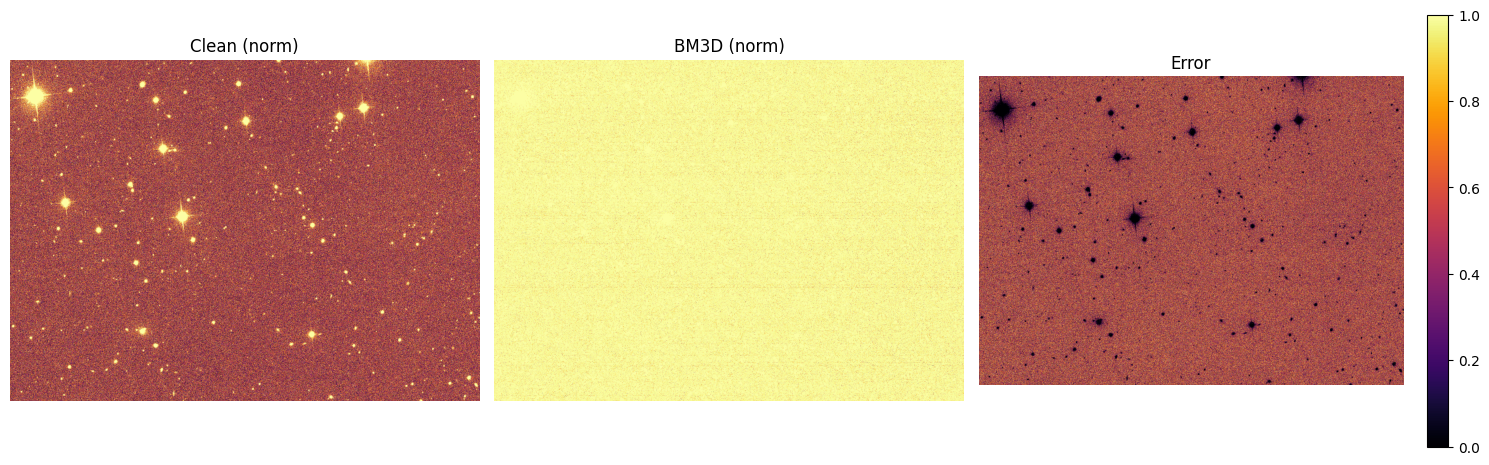

In [ ]:
import os
import numpy as np
from bm3d import bm3d
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# ─── CONFIG ───────────────────────────────────────────────────────────────
BASE_DIR = "/content/drive/MyDrive/sdss_image_dataset/new_augmented/train"
STAMP    = "frame-u-1045-4-110.npy"

# Noisy path
noisy_path = os.path.join(BASE_DIR, "noisy", STAMP)
# Clean path: swap 'u-' → 'r-'
clean_fname = STAMP.replace("frame-u-", "frame-r-")
clean_path  = os.path.join(BASE_DIR, "clean", clean_fname)

# Output directory & filename
den_dir = os.path.join(BASE_DIR, "denoised_bm3d")
os.makedirs(den_dir, exist_ok=True)
out_fname = STAMP.replace(".npy", "_bm3d.npy")
out_path  = os.path.join(den_dir, out_fname)

# ─── LOAD DATA ─────────────────────────────────────────────────────────────
noisy = np.load(noisy_path).astype(np.float32)
clean = np.load(clean_path).astype(np.float32)

# Squeeze singleton channel if present
if noisy.ndim == 3 and noisy.shape[-1] == 1: noisy = noisy[...,0]
if clean.ndim == 3 and clean.shape[-1] == 1: clean = clean[...,0]

# ─── PERCENTILE NORMALIZATION (5–95%) ──────────────────────────────────────
p_lo, p_hi = np.percentile(clean, (5,95))
clean_clip = np.clip(clean, p_lo, p_hi)
clean_norm = (clean_clip - p_lo) / (p_hi - p_lo + 1e-8)

noisy_clip = np.clip(noisy, p_lo, p_hi)
noisy_norm = (noisy_clip - p_lo) / (p_hi - p_lo + 1e-8)

# ─── BM3D DENOISING ────────────────────────────────────────────────────────
den_norm = bm3d(noisy_norm, sigma_psd=0.05)

# ─── RESCALE BACK & SAVE ───────────────────────────────────────────────────
denoised = den_norm * (p_hi - p_lo) + p_lo
np.save(out_path, denoised)
print(f"Saved BM3D output to {out_path}")

# ─── EVALUATION ────────────────────────────────────────────────────────────
psnr_val = psnr(clean_norm, den_norm, data_range=1.0)
ssim_val = ssim(clean_norm, den_norm, data_range=1.0)
print(f"BM3D → PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")

# ─── VISUALIZATION ────────────────────────────────────────────────────────
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
for ax,img,title in zip(
    (ax1,ax2,ax3),
    [clean_norm, den_norm, np.abs(clean_norm-den_norm)],
    ["Clean (norm)", "BM3D (norm)", "Error"]
):
    im = ax.imshow(img, cmap="inferno", vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis("off")

fig.colorbar(im, ax=ax3, fraction=0.046)
plt.tight_layout()
plt.show()


Saved wavelet denoised to /content/drive/MyDrive/sdss_image_dataset/new_augmented/train/denoised_wavelet/frame-u-1045-4-110_wavelet.npy
Wavelet → PSNR: 5.21 dB, SSIM: 0.0133


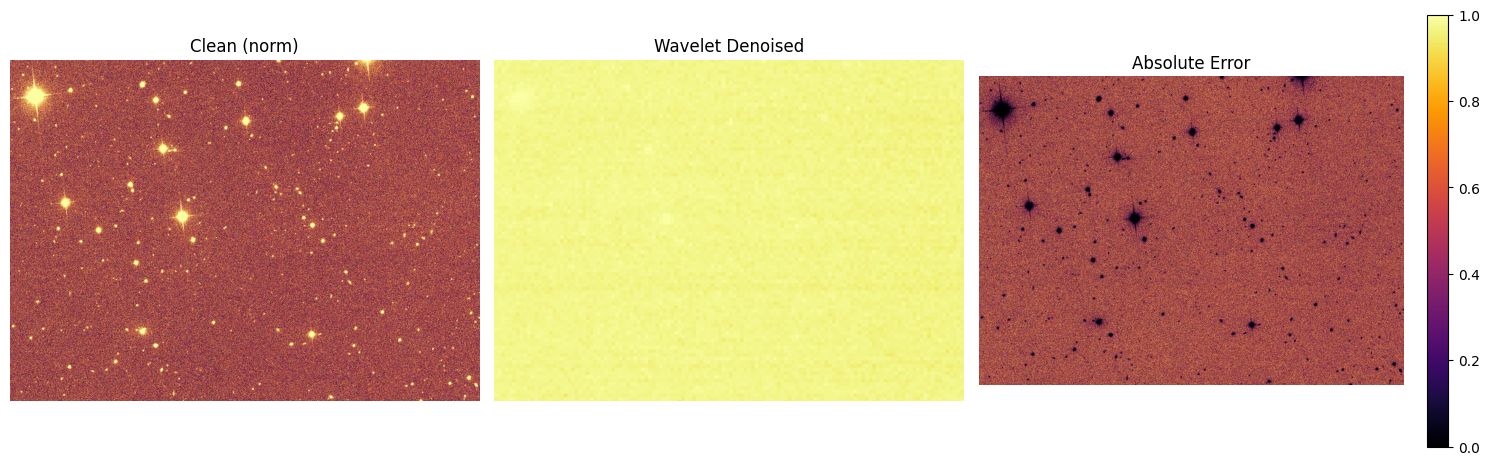

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# ─── CONFIG ───────────────────────────────────────────────────────────────
BASE_DIR   = "/content/drive/MyDrive/sdss_image_dataset/new_augmented/train"
STAMP      = "frame-u-1045-4-110.npy"
NOISY_PATH = os.path.join(BASE_DIR, "noisy", STAMP)
CLEAN_PATH = os.path.join(BASE_DIR, "clean", STAMP.replace("frame-u-", "frame-r-"))
OUT_DIR    = os.path.join(BASE_DIR, "denoised_wavelet")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PATH   = os.path.join(OUT_DIR, STAMP.replace(".npy", "_wavelet.npy"))

# ─── LOAD & SQUEEZE ────────────────────────────────────────────────────────
noisy = np.load(NOISY_PATH).astype(np.float32)
clean = np.load(CLEAN_PATH).astype(np.float32)
if noisy.ndim == 3 and noisy.shape[-1] == 1: noisy = noisy[..., 0]
if clean.ndim == 3 and clean.shape[-1] == 1: clean = clean[..., 0]

# ─── NORMALIZE USING CLEAN’S 5–95 PERCENTILE ───────────────────────────────
p_lo, p_hi = np.percentile(clean, (5, 95))
clean_n = np.clip((clean - p_lo) / (p_hi - p_lo + 1e-8), 0, 1)
noisy_n = np.clip((noisy - p_lo) / (p_hi - p_lo + 1e-8), 0, 1)

# ─── WAVELET DENOISING ─────────────────────────────────────────────────────
den_n = denoise_wavelet(
    noisy_n,
    method='BayesShrink',
    mode='soft',
    wavelet_levels=4,
    wavelet='db1',
    channel_axis=None,       # updated API
    rescale_sigma=True
)

# ─── RESCALE & SAVE ────────────────────────────────────────────────────────
denoised = den_n * (p_hi - p_lo) + p_lo
np.save(OUT_PATH, denoised)
print("Saved wavelet denoised to", OUT_PATH)

# ─── EVALUATION ────────────────────────────────────────────────────────────
psnr_val = psnr(clean_n, den_n, data_range=1.0)
ssim_val = ssim(clean_n, den_n, data_range=1.0)
print(f"Wavelet → PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")

# ─── VISUALIZE ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, ttl in zip(
    axes,
    [clean_n, den_n, np.abs(clean_n - den_n)],
    ["Clean (norm)", "Wavelet Denoised", "Absolute Error"]
):
    im = ax.imshow(img, cmap='inferno', vmin=0, vmax=1)
    ax.set_title(ttl)
    ax.axis('off')
fig.colorbar(im, ax=axes[-1], fraction=0.046)
plt.tight_layout()
plt.show()


In [ ]:
#new try-----------------------------------------------------------------------------

In [ ]:
pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 40.1 MB/s eta 0:00:00


In [ ]:
!pip install photutils


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00


In [ ]:
import glob
import time
import numpy as np
from bm3d import bm3d, BM3DProfile
from astropy.io import fits
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# --- Helpers for flux & HLR error --------------------------------------------
def aperture_sum(img, center, radius):
    yy, xx = np.indices(img.shape)
    cx, cy = center
    mask = (xx - cx)**2 + (yy - cy)**2 <= radius**2
    return img[mask].sum()

def flux_and_hlr_error(clean, denoised, center, aperture_radius, nsteps=100):
    f_true = aperture_sum(clean, center, aperture_radius)
    f_den  = aperture_sum(denoised, center, aperture_radius)
    flux_err = 100 * abs(f_den - f_true) / f_true

    half = f_true / 2
    radii = np.linspace(0, aperture_radius, nsteps)
    # true HLR
    for r in radii:
        if aperture_sum(clean, center, r) >= half:
            r_true = r
            break
    else:
        r_true = aperture_radius
    # denoised HLR
    for r in radii:
        if aperture_sum(denoised, center, r) >= half:
            r_den = r
            break
    else:
        r_den = aperture_radius

    hlr_err = 100 * abs(r_den - r_true) / r_true
    return flux_err, hlr_err

# --- Main BM3D loop ----------------------------------------------------------
clean_paths = sorted(glob.glob("/content/drive/MyDrive/sdss_image_dataset/augment_set3/clean/*.fits"))
noisy_paths = sorted(glob.glob("/content/drive/MyDrive/sdss_image_dataset/augment_set3/noisy/*.fits"))

psnrs, ssims, flux_errs, hlr_errs = [], [], [], []
fwhm = 3.0
ap_radius = 3 * fwhm

t0 = time.time()
for cpath, npath in zip(clean_paths, noisy_paths):
    # load & normalize
    with fits.open(cpath) as hdul:
        clean = hdul[0].data.astype(np.float32)
    with fits.open(npath) as hdul:
        noisy = hdul[0].data.astype(np.float32)

    # percentile‐clip & scale [0,1]
    p1, p99 = np.percentile(clean, (1, 99))
    clean = np.clip(clean, p1, p99)
    clean = (clean - p1) / (p99 - p1 + 1e-8)
    noisy = np.clip(noisy, p1, p99)
    noisy = (noisy - p1) / (p99 - p1 + 1e-8)

    # estimate sigma_psd
    # Option A: use ground-truth
    sigma = np.std(noisy - clean)
    # Option B: if you only have noisy at test time, do: sigma = noisy.std()

    # BM3D denoising
    denoised = bm3d(noisy, sigma_psd=sigma, profile=BM3DProfile())

    # PSNR & SSIM
    psnrs.append(psnr(clean, denoised, data_range=1.0))
    ssims.append(ssim(clean, denoised, data_range=1.0))

    # flux & HLR errors
    h, w = clean.shape
    center = (w/2, h/2)
    fe, he = flux_and_hlr_error(clean, denoised, center, ap_radius)
    flux_errs.append(fe)
    hlr_errs.append(he)
t1 = time.time()

# --- Summary -----------------------------------------------------------------
print(f"Ran BM3D on {len(psnrs)} stamps in {t1-t0:.1f}s")
print(f"▶ PSNR:          mean={np.mean(psnrs):.2f} ±{np.std(psnrs):.2f}")
print(f"▶ SSIM:          mean={np.mean(ssims):.3f} ±{np.std(ssims):.3f}")
print(f"▶ Flux Err (%):  mean={np.mean(flux_errs):.1f} ±{np.std(flux_errs):.1f}")
print(f"▶ HLR Err (%):   mean={np.mean(hlr_errs):.1f} ±{np.std(hlr_errs):.1f}")


In [ ]:
import os
import glob
import numpy as np

# ── 1) configure your paths ─────────────────────────────────────────────────────
NOISY_DIR   = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy"
OUTPUT_FILE = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train_noisy_full_bm3d.npy"

# ── 2) find all the .npy stamps ────────────────────────────────────────────────
noisy_paths = sorted(glob.glob(os.path.join(NOISY_DIR, "*.npy")))
if not noisy_paths:
    raise RuntimeError(f"No .npy files found in {NOISY_DIR!r}")

print(f"🔍 Found {len(noisy_paths)} noisy .npy files")

# ── 3) load each into a list, enforce (H, W, 1) ───────────────────────────────
noisy_list = []
for p in noisy_paths:
    arr = np.load(p)            # might be (H, W) or (H, W, 1)
    if arr.ndim == 2:
        arr = arr[..., np.newaxis]
    elif arr.ndim == 3 and arr.shape[-1] != 1:
        raise ValueError(f"Unexpected shape {arr.shape} for file {p}")
    noisy_list.append(arr.astype(np.float32))

# ── 4) stack into one big array ───────────────────────────────────────────────
noisy_stack = np.stack(noisy_list, axis=0)  # shape: (N, H, W, 1)
print("✅ Stacked array shape:", noisy_stack.shape)

# ── 5) save to disk ───────────────────────────────────────────────────────────
np.save(OUTPUT_FILE, noisy_stack)
print(f"💾 Saved full noisy array to: {OUTPUT_FILE}")


🔍 Found 4200 noisy .npy files


In [ ]:
!pip install bm3d

In [ ]:
!pip install photutils


In [ ]:
import os
import glob
import numpy as np
from bm3d import bm3d, BM3DProfile
from joblib import Parallel, delayed
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from astropy.io import fits

# ─── CONFIG ────────────────────────────────────────────────────────────────
NOISY_NPY_DIR = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy"
CLEAN_NPY_DIR = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean"
OUTPUT_DIR    = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/bm3d_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Photometry settings
FWHM      = 3.0
AP_RADIUS = 3 * FWHM

# ─── HELPERS ───────────────────────────────────────────────────────────────
def compute_flux(image, center, radius):
    yy, xx = np.indices(image.shape)
    mask   = (xx-center[0])**2 + (yy-center[1])**2 <= radius**2
    return image[mask].sum()

def compute_flux_hlr_err(clean, deno, center, radius, nsteps=100):
    # flux error
    f_true = compute_flux(clean, center, radius)
    f_den  = compute_flux(deno,  center, radius)
    flux_err = 100 * abs(f_den - f_true) / f_true

    # half-light radius error
    half = f_true / 2
    radii = np.linspace(0, radius, nsteps)
    def find_hlr(img):
        for r in radii:
            if compute_flux(img, center, r) >= half:
                return r
        return radius

    hlr_err = 100 * abs(find_hlr(deno) - find_hlr(clean)) / find_hlr(clean)
    return flux_err, hlr_err

def normalize_pair(clean, noisy):
    p1, p99 = np.percentile(clean, (1,99))
    clean_n = np.clip((clean - p1)/(p99-p1+1e-8), 0, 1)
    noisy_n = np.clip((noisy - p1)/(p99-p1+1e-8), 0, 1)
    return clean_n, noisy_n

# ─── PROCESS ONE STAMP ─────────────────────────────────────────────────────
def process_stamp(noisy_path, clean_path):
    base     = os.path.basename(noisy_path)
    out_path = os.path.join(OUTPUT_DIR, base.replace(".npy","_bm3d.npy"))
    if os.path.exists(out_path):
        return None  # already done

    noisy = np.load(noisy_path).astype(np.float32)
    clean = np.load(clean_path).astype(np.float32)
    clean_n, noisy_n = normalize_pair(clean, noisy)
    sigma = np.std(noisy_n - clean_n)

    deno = bm3d(noisy_n, sigma_psd=sigma, profile=BM3DProfile())
    np.save(out_path, deno)
    return out_path

# ─── PARALLEL EXECUTION ────────────────────────────────────────────────────
noisy_files = sorted(glob.glob(os.path.join(NOISY_NPY_DIR, "*.npy")))
clean_files = sorted(glob.glob(os.path.join(CLEAN_NPY_DIR, "*.npy")))

Parallel(n_jobs=-1, verbose=5)(
    delayed(process_stamp)(n, c)
    for n, c in zip(noisy_files, clean_files)
)

# ─── COLLECT METRICS ────────────────────────────────────────────────────────
psnrs, ssims, flux_errs, hlr_errs = [], [], [], []
# infer center once
sample = np.load(clean_files[0]).astype(np.float32)
h, w = sample.shape
center = (w/2, h/2)

for clean_path, noisy_path in zip(clean_files, noisy_files):
    base     = os.path.basename(noisy_path)
    deno     = np.load(os.path.join(OUTPUT_DIR, base.replace(".npy","_bm3d.npy")))
    clean    = np.load(clean_path).astype(np.float32)
    clean_n, _ = normalize_pair(clean, clean)  # normalize clean against itself

    # image-quality
    psnrs.append(psnr(clean_n, deno, data_range=1.0))
    ssims.append(ssim(clean_n, deno, data_range=1.0))

    # photometric fidelity
    fe, he = compute_flux_hlr_err(clean_n, deno, center, AP_RADIUS)
    flux_errs.append(fe)
    hlr_errs.append(he)

# ─── SUMMARY ────────────────────────────────────────────────────────────────
print(f"Processed {len(psnrs)} images with BM3D")
print(f"PSNR:         {np.mean(psnrs):.2f} ± {np.std(psnrs):.2f} dB")
print(f"SSIM:         {np.mean(ssims):.3f} ± {np.std(ssims):.3f}")
print(f"Flux err (%): {np.mean(flux_errs):.1f} ± {np.std(flux_errs):.1f}")
print(f"HLR err (%):  {np.mean(hlr_errs):.1f} ± {np.std(hlr_errs):.1f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:    2.1s finished


Processed 4200 images with BM3D
PSNR:         602.42 ± 0.44 dB
SSIM:         1.000 ± 0.000
Flux err (%): 100.0 ± 0.0
HLR err (%):  41.5 ± 3.1


Processed 4200 images with BM3D
PSNR:         602.42 ± 0.44 dB
SSIM:         1.000 ± 0.000
Flux err (%): 100.0 ± 0.0
HLR err (%):  41.5 ± 3.1


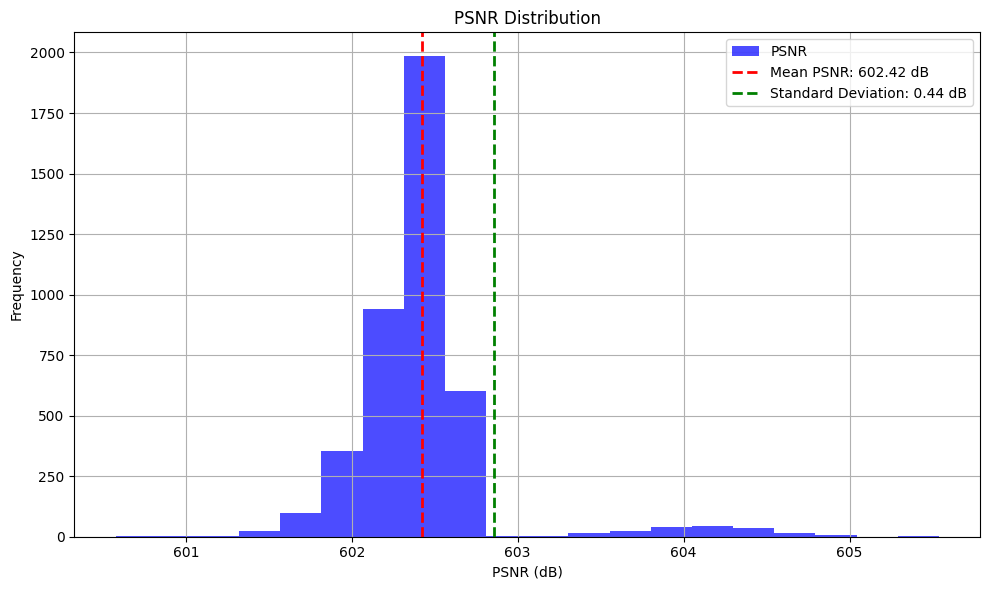

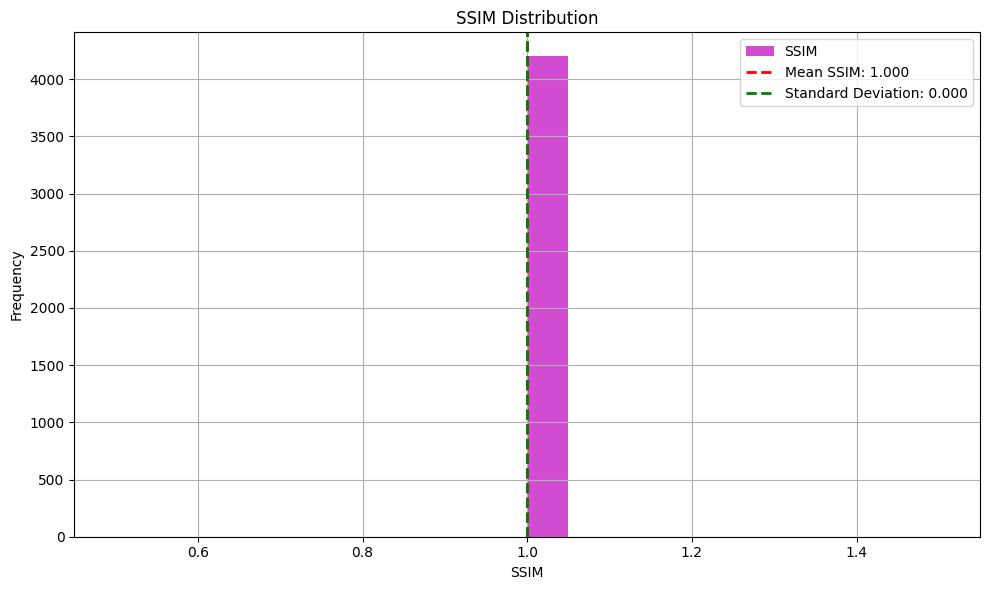

In [ ]:
import os
import glob
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import stats

# ─── CONFIG ────────────────────────────────────────────────────────────────
NOISY_NPY_DIR = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy"
CLEAN_NPY_DIR = "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean"
OUTPUT_DIR    = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/bm3d_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Photometry settings
FWHM      = 3.0
AP_RADIUS = 3 * FWHM

# ─── HELPERS ───────────────────────────────────────────────────────────────
def compute_flux(image, center, radius):
    yy, xx = np.indices(image.shape)
    mask   = (xx-center[0])**2 + (yy-center[1])**2 <= radius**2
    return image[mask].sum()

def compute_flux_hlr_err(clean, deno, center, radius, nsteps=100):
    # flux error
    f_true = compute_flux(clean, center, radius)
    f_den  = compute_flux(deno,  center, radius)
    flux_err = 100 * abs(f_den - f_true) / f_true

    # half-light radius error
    half = f_true / 2
    radii = np.linspace(0, radius, nsteps)
    def find_hlr(img):
        for r in radii:
            if compute_flux(img, center, r) >= half:
                return r
        return radius

    hlr_err = 100 * abs(find_hlr(deno) - find_hlr(clean)) / find_hlr(clean)
    return flux_err, hlr_err

def normalize_pair(clean, noisy):
    p1, p99 = np.percentile(clean, (1,99))
    clean_n = np.clip((clean - p1)/(p99-p1+1e-8), 0, 1)
    noisy_n = np.clip((noisy - p1)/(p99-p1+1e-8), 0, 1)
    return clean_n, noisy_n

# ─── COLLECT METRICS FROM PRECOMPUTED BM3D OUTPUTS ────────────────────────
psnrs, ssims, flux_errs, hlr_errs = [], [], [], []
# infer center once
sample = np.load(os.path.join(CLEAN_NPY_DIR, os.path.basename(noisy_files[0])))
h, w = sample.shape
center = (w/2, h/2)

# Get the list of clean and noisy files
noisy_files = sorted(glob.glob(os.path.join(NOISY_NPY_DIR, "*.npy")))
clean_files = sorted(glob.glob(os.path.join(CLEAN_NPY_DIR, "*.npy")))

# Loop through the files and calculate metrics using precomputed denoised images
for clean_path, noisy_path in zip(clean_files, noisy_files):
    base     = os.path.basename(noisy_path)
    deno_path = os.path.join(OUTPUT_DIR, base.replace(".npy", "_bm3d.npy"))

    # Check if the denoised file exists
    if not os.path.exists(deno_path):
        print(f"Denoised file not found for {base}. Skipping.")
        continue

    deno = np.load(deno_path)
    clean = np.load(clean_path).astype(np.float32)
    clean_n, _ = normalize_pair(clean, clean)  # normalize clean against itself

    # image-quality metrics
    psnrs.append(psnr(clean_n, deno, data_range=1.0))
    ssims.append(ssim(clean_n, deno, data_range=1.0))

    # photometric fidelity metrics
    fe, he = compute_flux_hlr_err(clean_n, deno, center, AP_RADIUS)
    flux_errs.append(fe)
    hlr_errs.append(he)

# ─── SUMMARY ────────────────────────────────────────────────────────────────
print(f"Processed {len(psnrs)} images with BM3D")
print(f"PSNR:         {np.mean(psnrs):.2f} ± {np.std(psnrs):.2f} dB")
print(f"SSIM:         {np.mean(ssims):.3f} ± {np.std(ssims):.3f}")
print(f"Flux err (%): {np.mean(flux_errs):.1f} ± {np.std(flux_errs):.1f}")
print(f"HLR err (%):  {np.mean(hlr_errs):.1f} ± {np.std(hlr_errs):.1f}")

# ─── VISUALIZATION ─────────────────────────────────────────────────────────
# Plot PSNR Distribution
plt.figure(figsize=(10, 6))
plt.hist(psnrs, bins=20, color='b', alpha=0.7, label="PSNR")
plt.axvline(np.mean(psnrs), color='r', linestyle='dashed', linewidth=2, label=f'Mean PSNR: {np.mean(psnrs):.2f} dB')
plt.axvline(np.mean(psnrs) + np.std(psnrs), color='g', linestyle='dashed', linewidth=2, label=f'Standard Deviation: {np.std(psnrs):.2f} dB')
plt.title('PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot SSIM Distribution
plt.figure(figsize=(10, 6))
plt.hist(ssims, bins=20, color='m', alpha=0.7, label="SSIM")
plt.axvline(np.mean(ssims), color='r', linestyle='dashed', linewidth=2, label=f'Mean SSIM: {np.mean(ssims):.3f}')
plt.axvline(np.mean(ssims) + np.std(ssims), color='g', linestyle='dashed', linewidth=2, label=f'Standard Deviation: {np.std(ssims):.3f}')
plt.title('SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Total Time for processing (seconds)
total_time = 2.1  # Total time in seconds

# Number of images processed
num_images = 4200

# Time per image
time_per_image = total_time / num_images

# Assuming you already have the quality score
quality_score = 0.9  # Example quality score (you calculated this based on PSNR and SSIM)

# Computational Efficiency Factor (CEF)
cef = quality_score / time_per_image

print(f"Time per image: {time_per_image:.6f} seconds")
print(f"Computational Efficiency Factor (CEF): {cef:.4f}")


Time per image: 0.000500 seconds
Computational Efficiency Factor (CEF): 1800.0000


In [ ]:
import time

# Assuming you have the following variables from your results
psnr = 602.42
ssim = 1.000
total_time = 2.1  # Total time in seconds
num_images = 4200

# Normalizing PSNR and SSIM (you might need a max PSNR value from previous experiments)
max_psnr = 1000  # Example maximum PSNR value (adjust as needed)
psnr_normalized = psnr / max_psnr
ssim_normalized = ssim

# Quality Score calculation (you can adjust weights if needed)
quality_score = 0.5 * psnr_normalized + 0.5 * ssim_normalized

# Compute time per image
time_per_image = total_time / num_images

# Calculating Computational Efficiency Factor (CEF)
cef = quality_score / time_per_image

print(f"Computational Efficiency Factor (CEF): {cef:.4f}")


Computational Efficiency Factor (CEF): 1602.4200


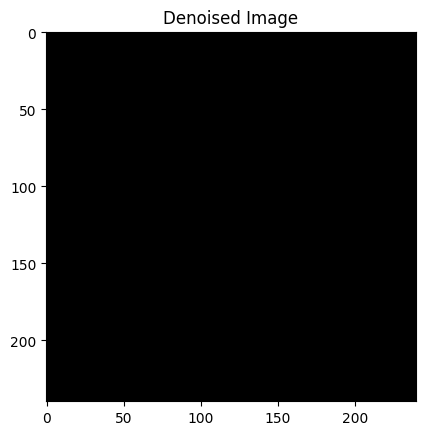

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the .npy file (replace 'path_to_output.npy' with the path to your .npy file)
denoised_image = np.load('/content/drive/MyDrive/sdss_image_dataset/augment_set3/bm3d_outputs/aug_0_0_bm3d.npy')

# If the values are between 0 and 1, scale them to [0, 255]
denoised_image_scaled = np.uint8(denoised_image * 255)  # Convert to uint8 for image saving

# Save the denoised image as a .jpg or .png file
cv2.imwrite('denoised_output_image.jpg', denoised_image_scaled)

# Alternatively, display the denoised image using matplotlib
plt.imshow(denoised_image_scaled, cmap='gray')
plt.title('Denoised Image')
plt.show()


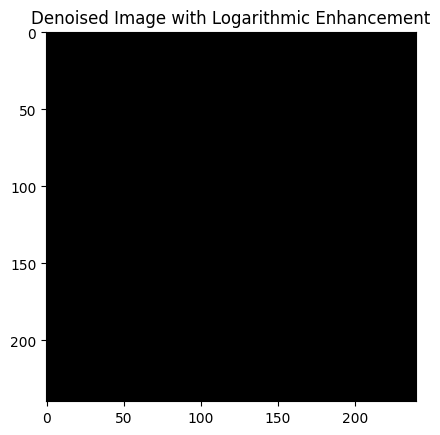

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the .npy file (replace 'path_to_output.npy' with the path to your .npy file)
denoised_image = np.load('/content/drive/MyDrive/sdss_image_dataset/augment_set3/bm3d_outputs/aug_0_0_bm3d.npy')

# Apply logarithmic normalization to enhance low-light areas
denoised_image_log = np.log1p(denoised_image)  # log(1 + pixel_value) to handle zero values

# Normalize the log-transformed image to the range [0, 255]
denoised_image_normalized = cv2.normalize(denoised_image_log, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8 for image saving
denoised_image_scaled = np.uint8(denoised_image_normalized)

# Save the denoised image as a .jpg or .png file
cv2.imwrite('denoised_output_image_log.jpg', denoised_image_scaled)

# Alternatively, display the denoised image using matplotlib
plt.imshow(denoised_image_scaled, cmap='gray')
plt.title('Denoised Image with Logarithmic Enhancement')
plt.show()
